In [1]:
%reset -f

In [5]:
import cv2
import imageio
import math
import sys

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tqdm.notebook as tqdm

In [6]:
print(f'Python version: {sys.version}')
print(f'Tensorflow version: {tf.__version__}')
print(f'Tensorflow GPU Devices: {tf.config.list_physical_devices(device_type="GPU")}')

Python version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Tensorflow version: 2.2.0
Tensorflow GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# body keypoint pairs, i.e. (neck, head)
BODY25_PAIRS = [
    (1, 8), (1,2), (1,5), (2,3), (3, 4), (5, 6), (6, 7), (8, 9), (9, 10), (10, 11),
    (8, 12), (12, 13), (13, 14), (1, 0), (0, 15), (15, 17), (0, 16), (16, 18), (2, 17), (5, 18),
    (14, 19) ,(19, 20), (14, 21), (11, 22), (22, 23), (11, 24),
]

MPI_PAIRS = [
    [0, 1], [1, 2], [2, 3], [3, 4], [1, 5], [5, 6], [6, 7], [1, 14],
    [14, 8], [8, 9], [9, 10], [14, 11], [11, 12], [12, 13],
]

HAND_PAIRS = [
    [0, 1],  [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8],[0, 9], [9, 10], [10, 11],
    [11, 12], [0, 13], [13, 14], [14, 15], [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]
]

# Integer encoded keypoint to natural language
BODY25_KEYPOINT_DICT = dict({
    0: "Nose",
    1: "Neck",
    2: "RShoulder",
    3: "RElbow",
    4: "RWrist",
    5: "LShoulder",
    6: "LElbow",
    7: "LWrist",
    8: "MidHip",
    9: "RHip",
    10: "RKnee",
    11: "RAnkle",
    12: "LHip",
    13: "LKnee",
    14: "LAnkle",
    15: "REye",
    16: "LEye",
    17: "REar",
    18: "LEar",
    19: "LBigToe",
    20: "LSmallToe",
    21: "LHeel",
    22: "RBigToe",
    23: "RSmallToe",
    24: "RHeel",
    25: "Background",
})

MPI_KEYPOINT_DICT = dict({
    0:  "Head",
    1:  "Neck",
    2:  "RShoulder",
    3:  "RElbow",
    4:  "RWrist",
    5:  "LShoulder",
    6:  "LElbow",
    7:  "LWrist",
    8:  "RHip",
    9:  "RKnee",
    10: "RAnkle",
    11: "LHip",
    12: "LKnee",
    13: "LAnkle",
    14: "Chest",
    15: "Background",
})

In [8]:
# CONFIG
MODEL_DIR = './models'
MODEL = 'BODY25'

N_POSE_KEYPOINTS = 25 if MODEL is 'BODY25' else 16
N_HAND_KEYPOINTS = 21
POSE_PAIRS = BODY25_PAIRS if MODEL is 'BODY25' else MPI_PAIRS

In [9]:
def plot(img):
    plt.figure(figsize=(15,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [10]:
# Specify the paths for the 2 files
pose_proto_file = f'{MODEL_DIR}/pose/body_25/pose_deploy.prototxt'
pose_weights_file = f'{MODEL_DIR}/pose/body_25/pose_iter_584000.caffemodel'

hand_proto_file = f'{MODEL_DIR}/hand/pose_deploy.prototxt'
hand_weights_file = f'{MODEL_DIR}/hand/pose_iter_102000.caffemodel'
 
# Read the network into Memory
pose_net = cv2.dnn.readNetFromCaffe(pose_proto_file, pose_weights_file)
hand_net = cv2.dnn.readNetFromCaffe(hand_proto_file, hand_weights_file)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\dnn\src\caffe\caffe_io.cpp:1121: error: (-2:Unspecified error) FAILED: fs.is_open(). Can't open "./models/pose/body_25/pose_deploy.prototxt" in function 'cv::dnn::ReadProtoFromTextFile'


In [3]:
def get_vid(file_path, frame_idx):
    vid = cv2.VideoCapture(file_path)
    idx = 0
    while vid.isOpened():
        ret, frame = vid.read()
        if ret and idx is frame_idx:
            return frame
        else:
            idx += 1

def get_img(file_path):
    return cv2.imread(file_path)
    
# single frame
# frame = get_img('./temp/pose_single1.jpg')

# low res frame
frame = get_vid('./temp/videos/BOER.mp4', 30)

# high res frame
frame = get_vid('./temp/highres/AANHALINGSTEKENS.mov', 50)

frame_height, frame_width, frame_channels = frame.shape
print(f'frame height: {frame_height}, frame width: {frame_width}, channels: {frame_channels}')

frame height: 720, frame width: 960, channels: 3


In [4]:
plot(frame)

NameError: name 'plot' is not defined

In [13]:
%%time
TARGET_SIZE = 368


# Prepare the frame to be fed to the network
NET_INPUT = cv2.dnn.blobFromImage(frame, 1.0 / 255, (TARGET_SIZE, TARGET_SIZE), (0, 0, 0))

pose_net.setInput(NET_INPUT)

pose_output = pose_net.forward()

print(f'pose_output.shape: {pose_output.shape}')

pose_output.shape: (1, 78, 46, 46)
Wall time: 3.6 s


Wall time: 69.5 ms


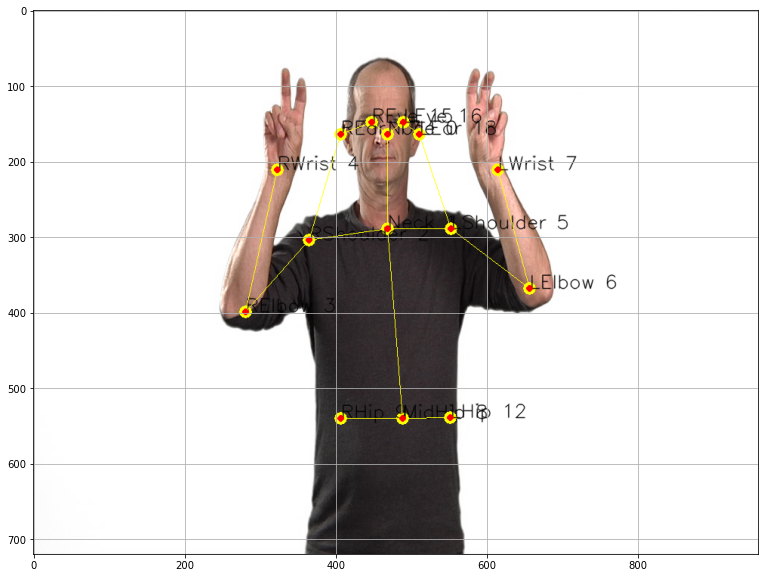

In [11]:
%%time
OUTPUT_H = pose_output.shape[2]
OUTPUT_W = pose_output.shape[3]
THRESHOLD = 0.10
frameCopy = frame.copy()

def pose_image(probability_maps, frame):
    points = dict()
    for idx, prob_map in enumerate(probability_maps[:N_POSE_KEYPOINTS]):
        # Find global maxima of the probMap.
        prob_map = cv2.resize(prob_map, (frame_width, frame_height))
        minVal, prob, minLoc, (p_x, p_y) = cv2.minMaxLoc(prob_map)

        if prob > THRESHOLD :
            CIRCLE_SIZE = int(math.sqrt(frame_width * frame_height) * 1e-2)
            cv2.circle(frame, (p_x, p_y), CIRCLE_SIZE, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            KEYPOINT_TEXT = BODY25_KEYPOINT_DICT[idx] + f' {idx}'
            TEXT_SIZE = math.sqrt(frame_width * frame_height) * 1e-3
            TEXT_THICKNESS = int(math.sqrt(frame_width * frame_height) * 2e-3)
            cv2.putText(frame, KEYPOINT_TEXT, (p_x, p_y), cv2.FONT_HERSHEY_SIMPLEX, TEXT_SIZE, (0, 0, 0), TEXT_THICKNESS, lineType=cv2.LINE_AA)

            # Add the point to the list if the probability is greater than the threshold
            points[BODY25_KEYPOINT_DICT[idx]] = (p_x, p_y)
        else :
            points[BODY25_KEYPOINT_DICT[idx]] = None
            
    # Draw Skeleton
    points_v = list(points.values())
    for (a, b) in POSE_PAIRS:
        if points_v[a] is not None and points_v[b] is not None:
            LINE_WIDTH = int(math.sqrt(frame_width * frame_height) * 2e-3)
            cv2.line(frame, points_v[a], points_v[b], (0, 255, 255), LINE_WIDTH)
            CIRCLE_SIZE = int(math.sqrt(frame_width * frame_height) * 5e-3)
            cv2.circle(frame, points_v[a], CIRCLE_SIZE, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.circle(frame, points_v[b], CIRCLE_SIZE, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
    
    return points

frame_points = []
for probability_maps in pose_output:
    frame_points.append(pose_image(probability_maps, frameCopy))


plot(frameCopy)

head_size: 136
rforearm_size: 192.634368688456
rhand_x: 337
rhand_y: 144
lforearm_size: 168.7986966774329
lhand_x: 570
lhand_y: 147


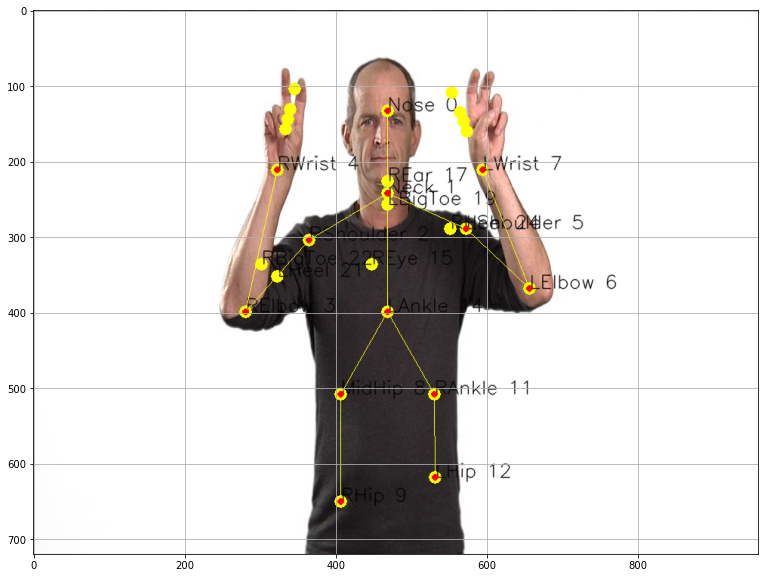

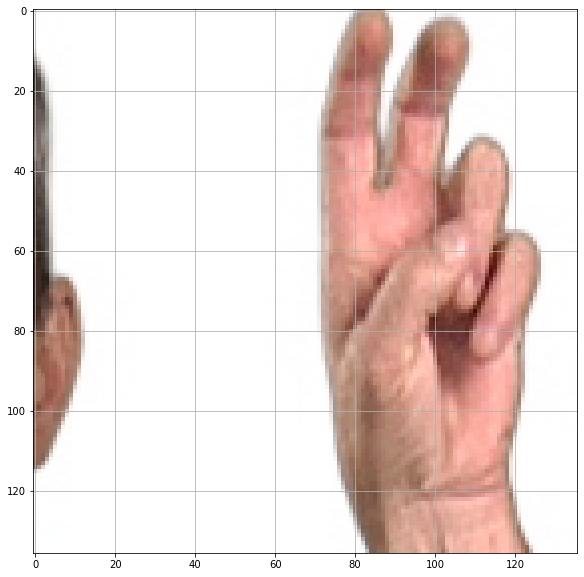

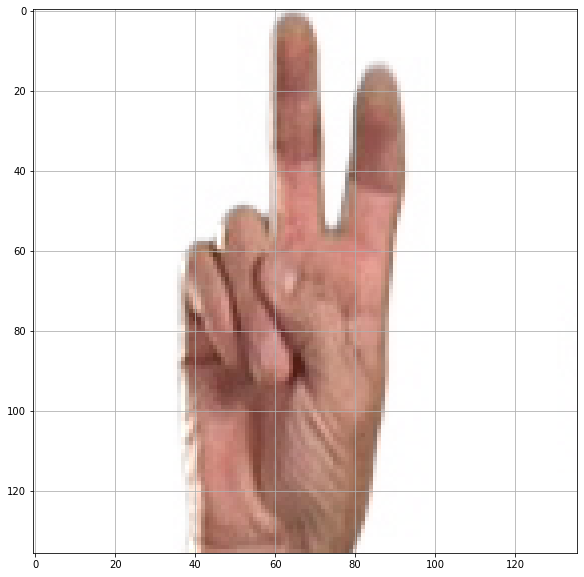

In [54]:
def distance_2points(p_x, p_y, q_x, q_y):
    return math.sqrt(abs(p_x - q_x)**2 + abs(p_y - q_y)**2)

def get_wrist_bbxs(points, frameCopy, frame):
    hands = dict()
    if points['Nose'] is not None and points['Neck'] is not None:
        head_size = int(distance_2points(*points['Nose'], *points['Neck']))
        head_size = int(head_size * 1.25)
        print(f'head_size: {head_size}')
        
        if points['RElbow'] is not None and points['RWrist'] is not None:
            relbow_x, relbow_y = points['RElbow']
            rwrist_x, rwrist_y = points['RWrist']
            rforearm_size = distance_2points(relbow_x, relbow_y, rwrist_x, rwrist_y)
            print(f'rforearm_size: {rforearm_size}')
            rhand_x = int(rwrist_x + 0.50 * head_size * (rwrist_x - relbow_x) / rforearm_size)
            print(f'rhand_x: {rhand_x}')
            rhand_y = int(rwrist_y + 0.50 * head_size * (rwrist_y- relbow_y) / rforearm_size)
            print(f'rhand_y: {rhand_y}')
            rhand_bbx_x = int(rhand_x - 0.50 * head_size)
            rhand_bbx_y = int(rhand_y - 0.50 * head_size)
            hands['rhand'] = frame[rhand_bbx_y:rhand_bbx_y+head_size, rhand_bbx_x:rhand_bbx_x+head_size]
            
            CIRCLE_SIZE = int(math.sqrt(frame_width * frame_height) * 1e-2)
            cv2.circle(frameCopy, (rhand_x, rhand_y), CIRCLE_SIZE, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            
        if points['LElbow'] is not None and points['LWrist'] is not None:
            lelbow_x, lelbow_y = points['LElbow']
            lwrist_x, lwrist_y = points['LWrist']
            lforearm_size = distance_2points(lelbow_x, lelbow_y, lwrist_x, lwrist_y)
            print(f'lforearm_size: {lforearm_size}')
            lhand_x = int(lwrist_x + 0.50 * head_size * (lwrist_x - lelbow_x) / lforearm_size)
            print(f'lhand_x: {lhand_x}')
            lhand_y = int(lwrist_y + 0.50 * head_size * (lwrist_y- lelbow_y) / lforearm_size)
            print(f'lhand_y: {lhand_y}')
            
            lhand_bbx_x = int(lhand_x - 0.50 * head_size)
            lhand_bbx_y = int(lhand_y - 0.50 * head_size)
            hands['lhand'] = frame[lhand_bbx_y:lhand_bbx_y+head_size, lhand_bbx_x:lhand_bbx_x+head_size]
            
            CIRCLE_SIZE = int(math.sqrt(frame_width * frame_height) * 1e-2)
            cv2.circle(frameCopy, (lhand_x, lhand_y), CIRCLE_SIZE, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            
    return hands
        
frame_hands = []
for points in frame_points:
    frame_hands.append(get_wrist_bbxs(points, frameCopy, frame))
    
plot(frameCopy)
plot(frame_hands[0]['lhand'])
plot(frame_hands[0]['rhand'])

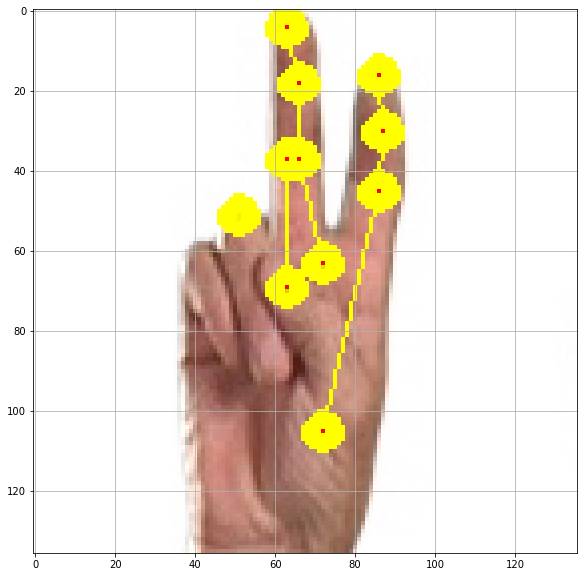

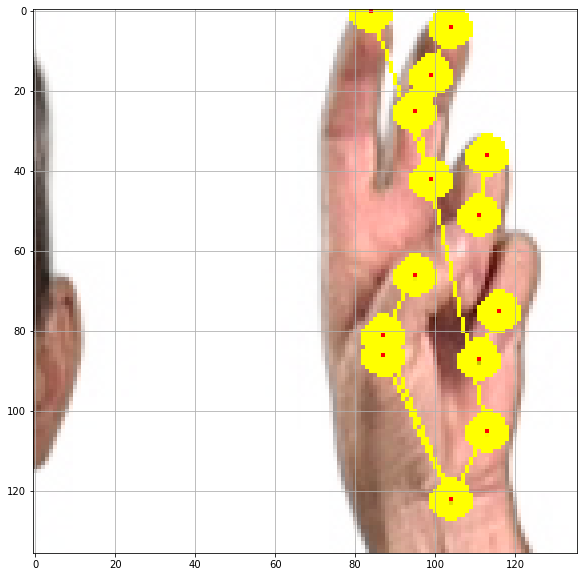

In [55]:
def get_hand_keypoints(frame):
    w, h, c = frame.shape
    points = []
    threshold = 0.10
    
    # Prepare the frame to be fed to the network
    NET_INPUT = cv2.dnn.blobFromImage(frame, 1.0 / 255, (TARGET_SIZE, TARGET_SIZE), (0, 0, 0))

    hand_net.setInput(NET_INPUT)
    hand_output = hand_net.forward()
    
    for idx, prob_map in enumerate(hand_output[0][:N_HAND_KEYPOINTS]):        
        prob_map = cv2.resize(prob_map, (w, h))
        minVal, prob, minLoc, (p_x, p_y) = cv2.minMaxLoc(prob_map)

        if prob > threshold:
            CIRCLE_SIZE = 5
            cv2.circle(frame, (p_x, p_y), CIRCLE_SIZE, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            TEXT_SIZE = int(w * h * 5e-7)
            TEXT_THICKNESS = int(w * h * 1e-6)
            cv2.putText(frame, str(idx), (p_x, p_y), cv2.FONT_HERSHEY_SIMPLEX, TEXT_SIZE, (0, 0, 0), TEXT_THICKNESS, lineType=cv2.LINE_AA)

            # Add the point to the list if the probability is greater than the threshold
            points.append((p_x, p_y))
        else :
            points.append(None)
            
    # Draw Skeleton
    points_v = points
    for (a, b) in HAND_PAIRS:
        if points_v[a] is not None and points_v[b] is not None:
            LINE_WIDTH = max(1, int(math.sqrt(w * h) * 2e-3))
            cv2.line(frame, points_v[a], points_v[b], (0, 255, 255), LINE_WIDTH)
            CIRCLE_SIZE = int(math.sqrt(w * h) * 5e-3)
            cv2.circle(frame, points_v[a], CIRCLE_SIZE, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.circle(frame, points_v[b], CIRCLE_SIZE, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            
    plot(frame)
            
for hands in frame_hands:
    for name, hand_frame in hands.items():
        hand_frame_copy = hand_frame.copy()
        get_hand_keypoints(hand_frame_copy)